# MFCC

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
import os
import math
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Concatenate, Dense, Dropout, TimeDistributed, LSTM
from keras.layers import Layer
from tensorflow.keras import Model

In [ ]:
DATASET_PATH = "sound - robot"
JSON_PATH = "model_robot/data_sound.json"
SAMPLE_RATE = 16000
TRACK_DURATION = 1 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T

                if len(mfcc) == num_mfcc_vectors_per_segment:
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i-1)
                    print("{}".format(file_path))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)

# Data Load

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Flatten, Concatenate, Dense, Dropout, TimeDistributed, LSTM
import matplotlib.pyplot as plt
from keras.layers import Layer
from tensorflow.keras import Model
import tensorflow.keras as keras

In [ ]:
DATA_PATH = "model_robot/data_sound.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

# Conv2D

In [52]:
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [53]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [54]:
from keras import backend as K

In [55]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape = Input(shape= input_shape)

In [56]:
# 1st conv layer
model_cnn1 = Conv2D(8, (2, 2), activation='relu', padding='same')(input_shape)
model_cnn1 = Conv2D(16, (2, 2), activation='relu', padding='same')(input_shape)

In [57]:
# 2nd conv layer
model_cnn2 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_shape)
model_cnn2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_shape)

In [58]:
# 3rd conv layer
model_cnn3 = Conv2D(8, (5, 5), activation='relu', padding='same')(input_shape)
model_cnn3 = Conv2D(16, (5, 5), activation='relu', padding='same')(input_shape)

In [59]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [84]:
model_cnn_con = Concatenate()([model_cnn1, model_cnn2, model_cnn3])

# Fully connected 
FC1 = Dense(64, activation='relu')(model_cnn_con)
FC2 = Dropout(0.3)(FC1)
FC2 = Dense(32, activation='relu')(FC2)

model_lstm = TimeDistributed(Flatten())(FC2)
model_lstm = LSTM(8, return_sequences=True)(model_lstm)
att_out=attention()(model_lstm)

output = Dense(4, activation= 'softmax')(att_out)

model_cnn = Model(inputs= [input_shape], outputs= output)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
model_cnn.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 13, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 13, 16)   80          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 13, 16)   160         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 13, 16)   416         input_4[0][0]                    
____________________________________________________________________________________________

In [86]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
8/8 [==============================] - 2s 89ms/step - loss: 1.4381 - accuracy: 0.2546 - val_loss: 1.3944 - val_accuracy: 0.3125
Epoch 2/50
8/8 [==============================] - 0s 28ms/step - loss: 1.4344 - accuracy: 0.2553 - val_loss: 1.3738 - val_accuracy: 0.3125
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 1.3765 - accuracy: 0.2576 - val_loss: 1.3538 - val_accuracy: 0.2969
Epoch 4/50
8/8 [==============================] - 0s 29ms/step - loss: 1.3725 - accuracy: 0.2546 - val_loss: 1.3310 - val_accuracy: 0.3438
Epoch 5/50
8/8 [==============================] - 0s 33ms/step - loss: 1.3741 - accuracy: 0.2782 - val_loss: 1.3257 - val_accuracy: 0.3906
Epoch 6/50
8/8 [==============================] - 0s 36ms/step - loss: 1.3519 - accuracy: 0.3494 - val_loss: 1.3347 - val_accuracy: 0.3906
Epoch 7/50
8/8 [==============================] - 0s 30ms/step - loss: 1.3289 - accuracy: 0.4182 - val_loss: 1.3035 - val_accuracy: 0.4219
Epoch 8/50
8/8 [===========

In [87]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.savefig('plot.png')
    plt.show()

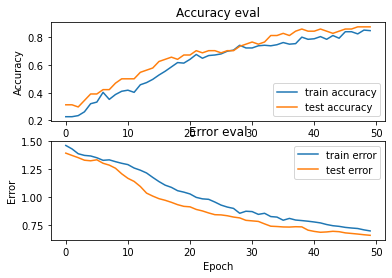

In [88]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [89]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.6878 - accuracy: 0.8375

Test accuracy: 0.8374999761581421


In [90]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [91]:
yhat_classes = np.argmax(model_cnn.predict(X_test), axis=1)

In [92]:
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='micro')
print('F1 score: %f' % f1)

Precision: 0.864719
Recall: 0.858202
F1 score: 0.830774
Precision: 0.837500
Recall: 0.837500
F1 score: 0.837500


In [93]:
#model_cnn.save("model_robot/Speech_to_Text")

In [94]:
#model_cnn.save("model_robot/Speech_to_Text.tf")